# Introduction
This competition will be hard. Here is my first experiment outcomes:
- Random prediction got 0.478 acc
- Models with training set go the same acc
- Models with 3K random purchase got 0.67 acc
- Models with 10K (all purchase) got 0.69 acc

# Data Downloading

In [1]:
from IPython.display import clear_output

root_dir = "/content"
!cd $root_dir

!gdown --id  1hOBoA1gsUSqGMjqKVjVL00X4MPA3WgSy
!gdown --id 1ks-qMyqh5rnrqmkbFQiMwk7BXTx32h6D
!gdown --id 1vUX2rAKg9A2CRUZXWq9vyK5-j8CXyegt
clear_output()

!tar -xvf training.tar.gz
!tar -xvf unlabelled.tar.gz
!tar -xvf validation.tar.gz
clear_output()

!cd $root_dir

In [2]:
!mkdir -p $root_dir/input
!cd $root_dir
!mv training* $root_dir/input
!mv unlabelled* $root_dir/input
!mv validation* $root_dir/input

# Libraries

In [3]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
clear_output()
%matplotlib inline

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric

print_config()

MONAI version: 0.9.dev2206
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1cd65b599e1439e3507a05197c3a290b9aca9305
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 4.2.1
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Data Prepraration

In [5]:
import pandas as pd
import numpy as np

In [6]:
all_classes = ['scratch_small', 'scratch_large', 'dent_small', 'dent_large']

def get_frame(filename):
    df = pd.read_csv(filename)
    pos = [df[df[c] == 1].shape[0] for c in all_classes]
    pos += [df.shape[0]]

    image_dir = "/".join(filename.split("/")[:-1]) + "/images/"
    df["filepath"] = df["filename"].apply(lambda s: image_dir + s)

    print(filename, df.shape)
    print("count:", pos)
    return df, pos

df_train, pos_train = get_frame(f"{root_dir}/input/training/labels.csv")
df_train.head()

/content/input/training/labels.csv (5000, 6)
count: [1273, 855, 1226, 589, 5000]


filename  ...                                       filepath
0  002YxUqF3Q.png  ...  /content/input/training/images/002YxUqF3Q.png
1  00Fo8XYcvC.png  ...  /content/input/training/images/00Fo8XYcvC.png
2  02s1G8Wwg8.png  ...  /content/input/training/images/02s1G8Wwg8.png
3  035EI0mrFh.png  ...  /content/input/training/images/035EI0mrFh.png
4  0385gp8ksf.png  ...  /content/input/training/images/0385gp8ksf.png

[5 rows x 6 columns]

In [7]:
df_val, pos_val = get_frame(f"{root_dir}/input/validation/labels.csv")
df_val.head()

/content/input/validation/labels.csv (3000, 6)
count: [788, 538, 680, 348, 3000]


filename  ...                                         filepath
0  000XeKZjyo.png  ...  /content/input/validation/images/000XeKZjyo.png
1  01g3s4Cps8.png  ...  /content/input/validation/images/01g3s4Cps8.png
2  039iQ7uPxX.png  ...  /content/input/validation/images/039iQ7uPxX.png
3  05dwOdxVfr.png  ...  /content/input/validation/images/05dwOdxVfr.png
4  06JHQtyeMm.png  ...  /content/input/validation/images/06JHQtyeMm.png

[5 rows x 6 columns]

In [8]:
df_unlabelled, pos_unlabelled = get_frame(f"{root_dir}/input/unlabelled/labels.csv")
df_unlabelled.head()

/content/input/unlabelled/labels.csv (10000, 6)
count: [2607, 1784, 2281, 1148, 10000]


filename  ...                                         filepath
0  00O1rwvydO.png  ...  /content/input/unlabelled/images/00O1rwvydO.png
1  01bB3DVokm.png  ...  /content/input/unlabelled/images/01bB3DVokm.png
2  01sAbrP4Gm.png  ...  /content/input/unlabelled/images/01sAbrP4Gm.png
3  02XiKLPuxY.png  ...  /content/input/unlabelled/images/02XiKLPuxY.png
4  02bVIX0aMT.png  ...  /content/input/unlabelled/images/02bVIX0aMT.png

[5 rows x 6 columns]

## Let's see the distribution - seems all sets have same distribution

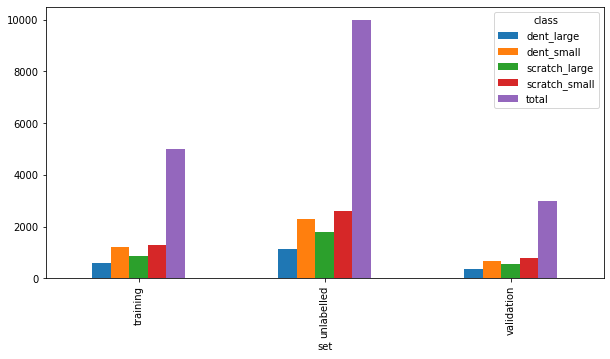

In [9]:
rows = []
for name, pos in zip(["training", "validation", "unlabelled"],
                      [pos_train, pos_val, pos_unlabelled]):
    for col, p in zip(all_classes + ["total"], pos):
        rows.append((name, col, p))
df_count = pd.DataFrame(rows, columns=["set", "class", "count"])
df_count

df_count.pivot(index='set', columns='class', values='count').plot(kind='bar', figsize=(10,5))

## Let's see images

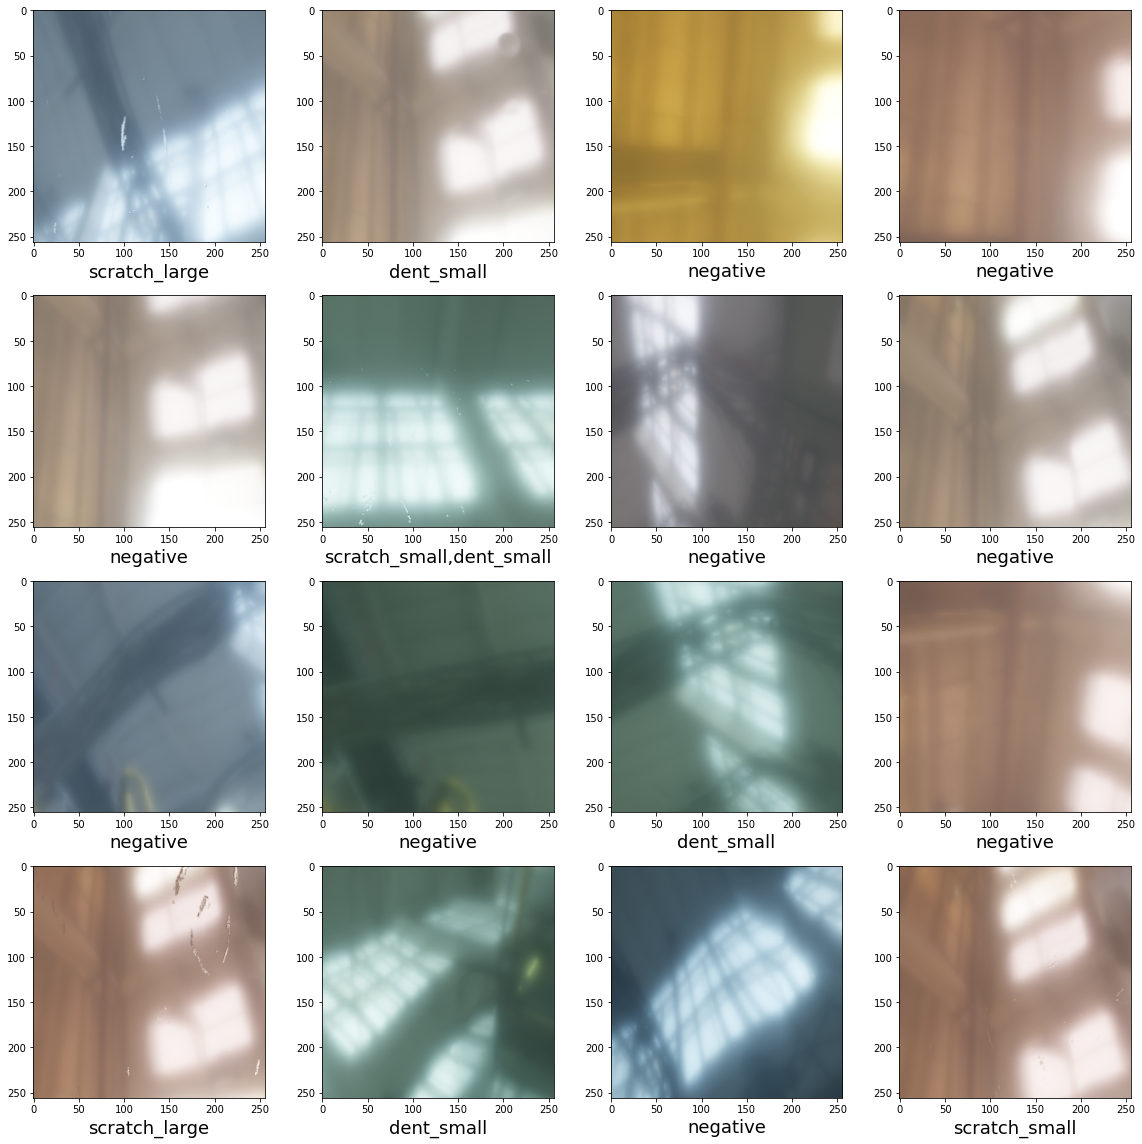

In [10]:
plt.subplots(4, 4, figsize=(16, 16))

train_dir = f"{root_dir}/input/training/images"

def get_text_lables(row):
    label = [c for c in all_classes if row[c] > 0]
    if len(label) > 0:
        return ",".join(label)
    else:
        return "negative"

for i, row in df_train.sample(16).reset_index(drop=True).iterrows():
    filename = row["filename"]
    im = PIL.Image.open(f"{train_dir}/{filename}")
    arr = np.array(im)
    plt.subplot(4, 4, i + 1)
    plt.xlabel(get_text_lables(row), fontsize=18)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

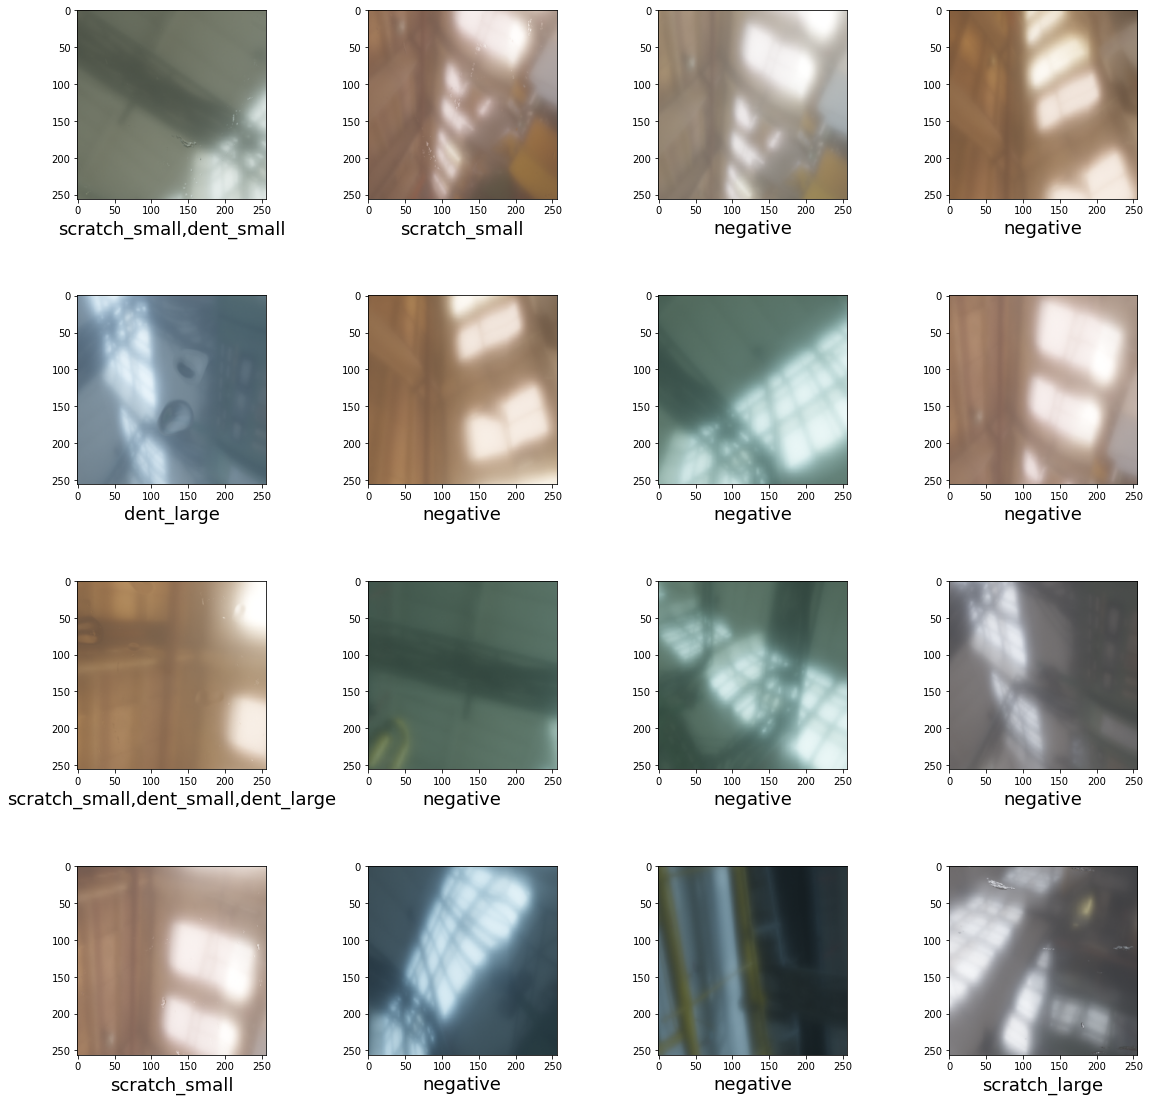

In [11]:
plt.subplots(4, 4, figsize=(16, 16))

for i, row in df_val.sample(16).reset_index(drop=True).iterrows():
    filename = row["filepath"]
    im = PIL.Image.open(filename)
    arr = np.array(im)
    plt.subplot(4, 4, i + 1)
    plt.xlabel(get_text_lables(row), fontsize=18)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Models

## Pre-Training

In [ ]:
def train_models(phase, df_train, df_val, 
                 all_classes = all_classes,
                 model_arch = "efficientnet-b0"):
    !mkdir -p $root_dir/$phase
    print(df_train.shape, df_val.shape)

    from monai.networks.nets import EfficientNetBN
    from monai.utils import set_determinism

    from monai.transforms import (
        Activations,
        AddChannel,
        AsDiscrete,
        Compose,
        LoadImage,
        RandFlip,
        ScaleIntensity,
        EnsureType,
        Transpose,
        AsDiscrete
    )

    train_transforms = Compose( [
            LoadImage(image_only=True), Transpose((2, 0, 1)),
            ScaleIntensity(),
            RandFlip(spatial_axis=0, prob=0.5),
            EnsureType()
    ])

    val_transforms = Compose( [
            LoadImage(image_only=True), Transpose((2, 0, 1)),
            ScaleIntensity(), EnsureType()
    ])

    class BinaryDataset(torch.utils.data.Dataset):
        def __init__(self, image_files, labels, transforms):
            self.image_files = image_files
            self.labels = labels
            self.transforms = transforms

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, index):
            return self.transforms(self.image_files[index]), self.labels[index]

    y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
    y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

    set_determinism(seed=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    BATCH_SIZE = 96
    num_workers = 2

    for target_pos in range(len(all_classes)):
        #target_pos = 1
        target_col = all_classes[target_pos]
        print("-"*40)
        print("Processing ", target_col, " ...")

        train_x = list(df_train["filepath"])
        train_y = list(df_train[target_col])

        train_ds = BinaryDataset(train_x, train_y, train_transforms)
        train_loader = torch.utils.data.DataLoader(
            train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

        val_x = list(df_val["filepath"])
        val_y = list(df_val[target_col])

        val_ds = BinaryDataset(val_x, val_y, val_transforms)
        val_loader = torch.utils.data.DataLoader(
            val_ds, batch_size=BATCH_SIZE, num_workers=num_workers)


        model = EfficientNetBN(model_arch, pretrained=True, 
                              spatial_dims=2, in_channels=3, num_classes=2).to(device)

        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), 1e-5)
        auc_metric = ROCAUCMetric()

        val_interval = 1
        best_metric = -1
        best_metric_epoch = -1
        epoch_loss_values = []
        metric_values = []

        max_epochs = 10
        for epoch in range(max_epochs):
            print("-" * 10)
            print(f"epoch {epoch + 1}/{max_epochs}")
            model.train()
            epoch_loss = 0
            step = 0
            for batch_data in train_loader:
                step += 1
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                if step % 10 == 0:
                    print(
                        f"{step}/{len(train_ds) // train_loader.batch_size}, "
                        f"train_loss: {loss.item():.4f}")
                epoch_len = len(train_ds) // train_loader.batch_size

            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    y_pred = torch.tensor([], dtype=torch.float32, device=device)
                    y = torch.tensor([], dtype=torch.long, device=device)
                    for val_data in val_loader:
                        val_images, val_labels = (
                            val_data[0].to(device),
                            val_data[1].to(device),
                        )
                        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                        y = torch.cat([y, val_labels], dim=0)
                    y_onehot = [y_trans(i) for i in decollate_batch(y)]
                    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                    auc_metric(y_pred_act, y_onehot)
                    result = auc_metric.aggregate()
                    auc_metric.reset()
                    del y_pred_act, y_onehot
                    metric_values.append(result)
                    acc_value = torch.eq(y_pred.argmax(dim=1), y)
                    acc_metric = acc_value.sum().item() / len(acc_value)
                    if result > best_metric:
                        best_metric = result
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), 
                                  f"{root_dir}/{phase}/{target_col}_model.pth")
                        
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                        f" current accuracy: {acc_metric:.4f}"
                        f" best AUC: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )

        print(
            f"train completed, best_metric: {best_metric:.4f} "
            f"at epoch: {best_metric_epoch}")
        print("Terminated ", target_col, ".")
        print("-"*40)

phase = "Pre-Training"
train_models(phase, df_train, df_val)

(5000, 6) (3000, 6)
cuda
----------------------------------------
Processing  scratch_small  ...
----------
epoch 1/10
10/52, train_loss: 1.9284
20/52, train_loss: 1.6592
30/52, train_loss: 1.3136
40/52, train_loss: 1.0643
50/52, train_loss: 0.8533
epoch 1 average loss: 1.4337
saved new best metric model
current epoch: 1 current AUC: 0.5024 current accuracy: 0.7313 best AUC: 0.5024 at epoch: 1
----------
epoch 2/10
10/52, train_loss: 0.9700
20/52, train_loss: 0.9851
30/52, train_loss: 0.7243
40/52, train_loss: 0.7525
50/52, train_loss: 0.6600
epoch 2 average loss: 0.8006
saved new best metric model
current epoch: 2 current AUC: 0.5340 current accuracy: 0.7370 best AUC: 0.5340 at epoch: 2
----------
epoch 3/10
10/52, train_loss: 0.4773
20/52, train_loss: 0.7624
30/52, train_loss: 0.7097
40/52, train_loss: 0.1398
50/52, train_loss: 0.4809
epoch 3 average loss: 0.5461
current epoch: 3 current AUC: 0.3966 current accuracy: 0.7273 best AUC: 0.5340 at epoch: 2
----------
epoch 4/10
10/52, tr

In [ ]:
def predict(phase, list_filenames, 
                 all_classes = all_classes,
                 model_arch = "efficientnet-b0"):
    from monai.networks.nets import EfficientNetBN
    from monai.transforms import (
        Activations,
        AsDiscrete,
        Compose,
        LoadImage,
        ScaleIntensity,
        EnsureType,
        Transpose,
    )

    test_transforms = Compose( [
            LoadImage(image_only=True), Transpose((2, 0, 1)),
            ScaleIntensity(), EnsureType()
    ])

    class TestDataset(torch.utils.data.Dataset):
        def __init__(self, image_files, transforms):
            self.image_files = image_files
            self.transforms = transforms

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, index):
            return self.transforms(self.image_files[index])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    BATCH_SIZE = 96
    num_workers = 2
    all_preds = []

    for target_pos in range(len(all_classes)):
        #target_pos = 1
        target_col = all_classes[target_pos]
        print("-"*40)
        print("Processing ", target_col, " ...")

        test_x = list_filenames[:]
        test_ds = TestDataset(test_x, test_transforms)

        test_loader = torch.utils.data.DataLoader(
            test_ds, batch_size=BATCH_SIZE, num_workers=num_workers)


        model = EfficientNetBN(model_arch, pretrained=False, 
                              spatial_dims=2, in_channels=3, num_classes=2).to(device)


        model.load_state_dict(torch.load(f"{root_dir}/{phase}/{target_col}_model.pth", 
                                         map_location=torch.device(device)))
        model.to(device)
        model.eval()
        
        y_pred = []
        softmax = torch.nn.Softmax(dim=1)

        with torch.no_grad():
            for test_data in test_loader:
                test_images = test_data.to(device)
                pred = model(test_images)
                pred = softmax(pred).detach().cpu().numpy()
                y_pred.append(pred)
            
        y_pred = np.concatenate(y_pred)[:, 1]
        all_preds.append(y_pred)

        print("Terminated ", target_col, ".")
        print("-"*40)
    return all_preds

list_filenames = list(df_val["filepath"])
print(phase, len(list_filenames), list_filenames[:3])
all_preds = predict(phase, list_filenames)

In [ ]:
def print_metrics(all_preds, df_train, df_val):
    df_output = df_val[["filename"] + all_classes].copy()
    for i,col in enumerate(all_classes):
        df_output[f"prob_{col}"] = all_preds[i]
        q = df_train[df_train[col]==0].shape[0] / df_train.shape[0]
        q_threshold = df_output[f"prob_{col}"].quantile(q)
        #q_threshold = 0.5
        df_output[f"pred_{col}"] = (df_output[f"prob_{col}"]>=q_threshold).astype(int)
        
    return df_output

df_output = print_metrics(all_preds, df_train, df_val)
df_output

In [ ]:
from sklearn import metrics 
metrics.accuracy_score(df_output[all_classes], 
                       df_output[[f"pred_{col}" for col in all_classes]])

In [ ]:
metrics.accuracy_score(df_output[all_classes], 
                       np.zeros((df_output.shape[0], len(all_classes))))

## Purchase - random

In [ ]:
df_purchase = df_unlabelled.sample(n=3000).copy()
df_total = pd.concat([df_train,df_purchase]).reset_index(drop=True)
print(df_total.shape)

In [ ]:
phase = "Purchase"
train_models(phase, df_total, df_val)

In [ ]:
list_filenames = list(df_val["filepath"])
print(phase, len(list_filenames), list_filenames[:3])
all_preds = predict(phase, list_filenames)

df_output = print_metrics(all_preds, df_train, df_val)
df_output

# Random: 0.478
metrics.accuracy_score(df_output[all_classes], 
                       df_output[[f"pred_{col}" for col in all_classes]])

## Purchase all - ideal purchase

In [ ]:
df_total = pd.concat([df_train,df_unlabelled]).reset_index(drop=True)
print(df_total.shape)
df_total.tail()

In [ ]:
phase = "Purchase_all"
train_models(phase, df_total, df_val)

In [ ]:
list_filenames = list(df_val["filepath"])
print(phase, len(list_filenames), list_filenames[:3])
all_preds = predict(phase, list_filenames)

df_output = print_metrics(all_preds, df_train, df_val)
df_output

# Random: 0.478, Random purchase: 0.6696666666666666
metrics.accuracy_score(df_output[all_classes], 
                       df_output[[f"pred_{col}" for col in all_classes]])

In [ ]:
import time
for i in range(1000):
    time.sleep(60) # 1 min